In [10]:
path_to_directory = "C:/Users/Utilizador/OneDrive/Documentos/DS"

file_tag = "class_ny_arrests"

train_filename = f"{path_to_directory}/datasets/{file_tag}_smote.csv"
test_filename = f"{path_to_directory}/datasets/{file_tag}_test_redundant.csv"

In [11]:
from numpy import array, ndarray
from pandas import read_csv, DataFrame

target = "JURISDICTION_CODE"
data_train: DataFrame = read_csv(train_filename)
data_test: DataFrame = read_csv(test_filename)

labels: list = list(data_train[target].unique())
labels.sort()

sample_size = 0.03

print(f"Labels={labels}")
print("Before sampling")
print(data_train.shape)
print(data_test.shape)
data_train = data_train.sample(frac=sample_size, random_state=42)
data_test = data_test.sample(frac=sample_size, random_state=42)
print("After sampling for MLP")
print(data_train.shape)
print(data_test.shape)

positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {
    "Original": [
        len(data_train[data_train[target] == negative])+len(data_test[data_test[target] == negative]),
        len(data_train[data_train[target] == positive])+len(data_test[data_test[target] == positive]),
    ]
}

y_trn: array = data_train.pop(target).to_list()
X_trn: ndarray = data_train.values

y_tst: array = data_test.pop(target).to_list()
X_tst: ndarray = data_test.values



Labels=[0, 1]
Before sampling
(311632, 15)
(40000, 15)
After sampling for MLP
(9349, 15)
(1200, 15)


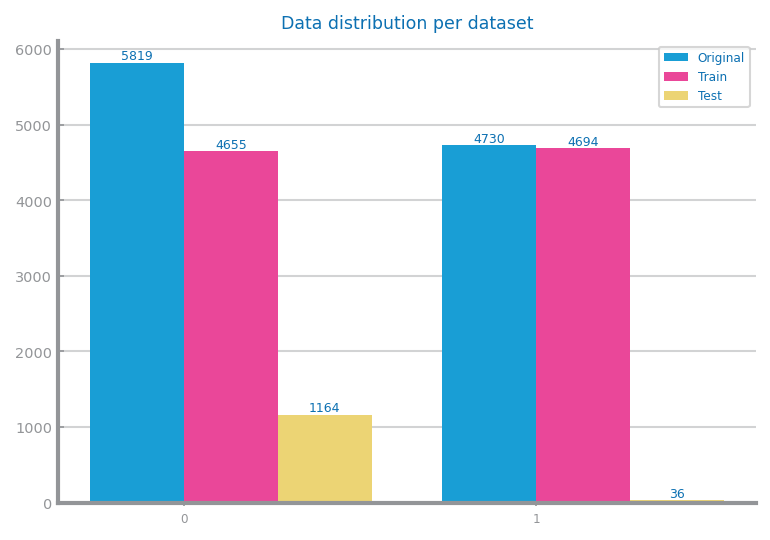

In [12]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart

#trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
trnX = X_trn
trnY = y_trn
tstX = X_tst
tstY = y_tst

train: DataFrame = concat(
    [DataFrame(trnX, columns=data_train.columns), DataFrame(trnY, columns=[target])], axis=1
)
train.to_csv(f"{path_to_directory}/datasets/{file_tag}_modeling_train.csv", index=False)

test: DataFrame = concat(
    [DataFrame(tstX, columns=data_test.columns), DataFrame(tstY, columns=[target])], axis=1
)
test.to_csv(f"{path_to_directory}/datasets/{file_tag}_modeling_test.csv", index=False)

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

Train#=9349 Test#=1200
Labels=[0, 1]
MLP best for 1500 iterations (lr_type=constant and lr=0.5


<Figure size 600x450 with 0 Axes>

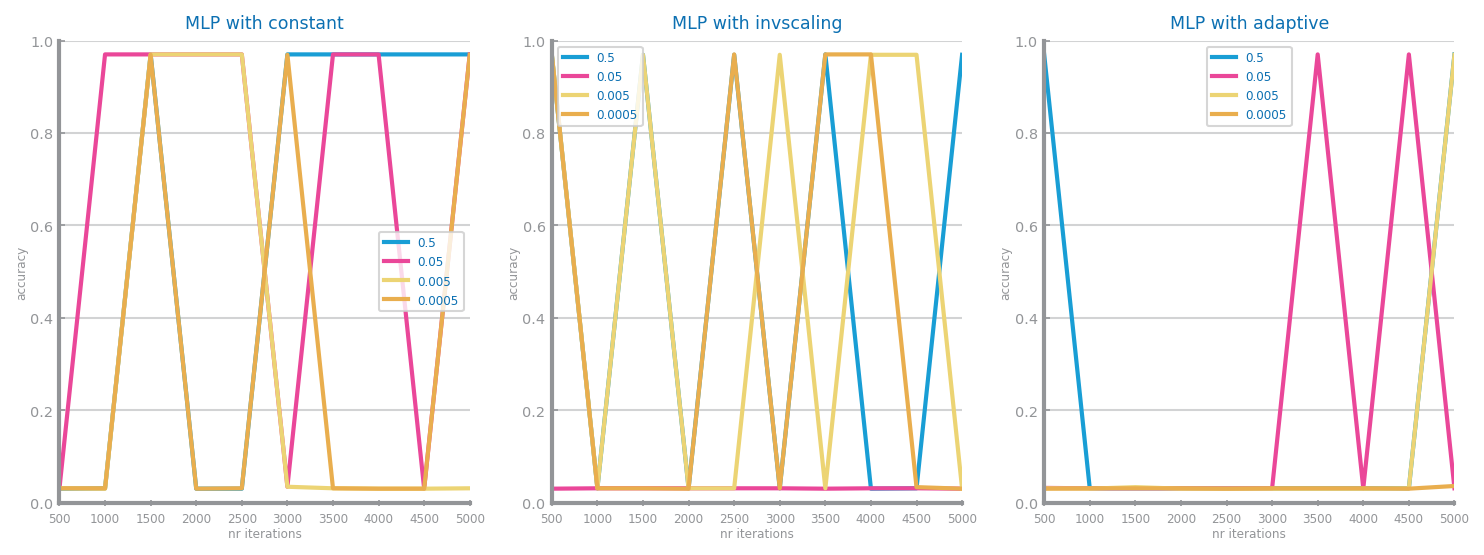

In [13]:
from numpy import array, ndarray, random
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.neural_network import MLPClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart

LAG: int = 500
NR_MAX_ITER: int = 5000
SAMPLE_SIZE: int = 5000  # Maximum size of the dataset

eval_metric = "accuracy"
def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[MLPClassifier | None, dict]:
    nr_iterations: list[int] = [lag] + [
        i for i in range(2 * lag, nr_max_iterations + 1, lag)
    ]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]  # only used if optimizer='sgd'
    learning_rates: list[float] = [0.5, 0.05, 0.005, 0.0005]

    best_model: MLPClassifier | None = None
    best_params: dict = {"name": "MLP", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    _, axs = subplots(
        1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False
    )
    for i in range(len(lr_types)):
        type: str = lr_types[i]
        values = {}
        for lr in learning_rates:
            warm_start: bool = False
            y_tst_values: list[float] = []
            for j in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False,
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                warm_start = True
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (type, lr, nr_iterations[j])
                    best_model = clf
            values[lr] = y_tst_values
        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"MLP with {type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'MLP best for {best_params["params"][2]} iterations (lr_type={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params



print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=NR_MAX_ITER,
    lag=LAG,
    metric=eval_metric,
)
savefig(f"{path_to_directory}/images/{file_tag}_mlp_{eval_metric}_study.png")
show()
